# Neural Network with Backpropagation From Scratch :)

This notebook will follow [this](https://medium.com/@curiousily/tensorflow-for-hackers-part-iv-neural-network-from-scratch-1a4f504dfa8) tutorial.  The purpose is to gain intuition about neural networks before eventually revisiting my work with TensorFlow.  After building this NN from scratch I will use TF to build an NN classifier from scratch instead of using the pre-built estimators.

This sets up the environment and seeds the random number generator.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

# Found these on tutorial author's Github
from preprocessing import *
from math_utils import *
from plotting import *

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

A visual comparison of the sigmoid function and its first derivative.  This is used as an activation function in the hidden layers of the model.

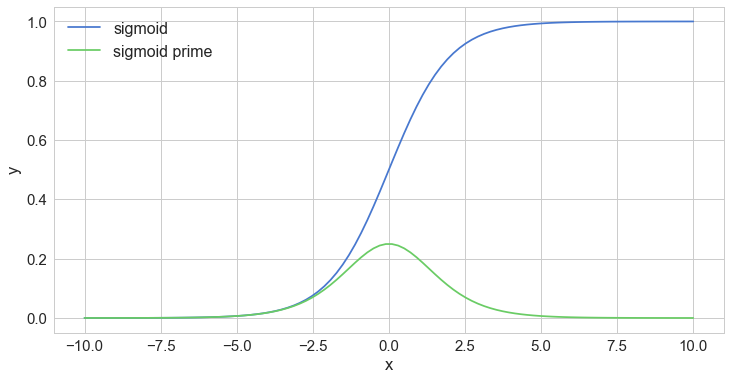

In [2]:
x = np.linspace(-10., 10., num=100)
sig = sigmoid(x)
sig_prime = sigmoid_prime(x)

plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

I will be trying to predict the values of the XOR function.

In [3]:
epochs = 50000
input_size, hidden_size, output_size = 2, 3, 1
LR = .1 # learning rate

X = np.array([[0,0], [0,1], [1,0], [1,1]])
y = np.array([ [0],   [1],   [1],   [0]])

# The hidden weights are between the input and hidden layer
# The output weights are between the hidden layer and the output layer
w_hidden = np.random.uniform(size=(input_size, hidden_size))
w_output = np.random.uniform(size=(hidden_size, output_size))

Below is the backpropagation algorithm.

In [4]:
for epoch in range(epochs):
    
    # Forward
    act_hidden = sigmoid(np.dot(X, w_hidden))
    output = np.dot(act_hidden, w_output)
    
    # Calculate error
    error = y - output
    
    if epoch % 5000 == 0:
        print(f'error sum {sum(error)}')

    # Backward
    dZ = error * LR # Partial deriv of cost w.r.t. z is error
    w_output += act_hidden.T.dot(dZ) # Second layer of weights updated by error scaled by activation
    # error scaled by new output weights and sigmoid prime activation of hidden layer
    dH = dZ.dot(w_output.T) * sigmoid_prime(act_hidden)
    # hidden weights now updated by multiplying scaled error with inputs
    w_hidden += X.T.dot(dH)

error sum [-1.77496016]
error sum [ 0.00586565]
error sum [ 0.00525699]
error sum [ 0.0003625]
error sum [-0.00064657]
error sum [ 0.00189532]
error sum [  3.79101898e-08]
error sum [  7.47615376e-13]
error sum [  1.40960742e-14]
error sum [  1.49842526e-14]


Now we can make predictions about each of the four test cases.

In [5]:
for X_test in X:
    act_hidden = sigmoid(np.dot(X_test, w_hidden))
    print(str(X_test) + ": " + str(np.dot(act_hidden, w_output)))

[0 0]: [  1.99840144e-14]
[0 1]: [ 1.]
[1 0]: [ 1.]
[1 1]: [  3.64153152e-14]


These results look pretty good, the True cases are completely correct while the False cases are very small numbers approaching zero, so basically correct.

# Classifier Time

This section will build an MNIST classifier without using the TensorFlow API.

In [6]:
# These are taken directly from http://yann.lecun.com/exdb/mnist/
IMAGES_PATH = 'train-images-idx3-ubyte'
LABELS_PATH = 'train-labels-idx1-ubyte'

N_FEATURES = 28 * 28
N_CLASSES = 10

In [67]:
X, y = read_mnist(IMAGES_PATH, LABELS_PATH)
X, y = shuffle_data(X, y, random_seed=RANDOM_SEED)
X_train, y_train = X[500:], y[500:] # From 500 onward
X_test, y_test = X[:500], y[:500] # First 500 pairs

The author of the tutorial provides the methods read_mnist and shuffle_data, as well as plot_digit which I will demo here.

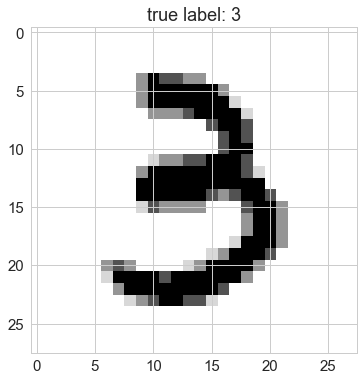

In [68]:
plot_digit(X, y, 1)

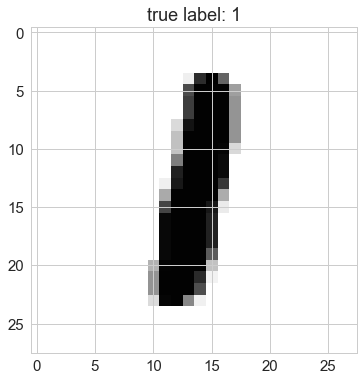

In [69]:
plot_digit(X, y, 1500)

I'm going to create the classifier in a separate class called NNClassifier (with comments by me).

In [70]:
class NNClassifier:
    
    # These params are pretty standard for a NN classifier, I think TF is very similar
    def __init__(self, n_classes, n_features, n_hidden_units=30,
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):
        
        # Recall that a random seed was set at the beginning so this is an optional param
        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.w1, self.w2 = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches
        
    def _init_weights(self):
        # w1 has weights between -1, 1 and shape [hidden_units, n_features+1]
        w1 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_hidden_units * (self.n_features + 1))
        w1 = w1.reshape(self.n_hidden_units, self.n_features + 1)
        
        # w2 has weights between -1, 1 and shape [n_classes, hidden_units+1]
        w2 = np.random.uniform(-1.0, 1.0, 
                               size=self.n_classes * (self.n_hidden_units + 1))
        w2 = w2.reshape(self.n_classes, self.n_hidden_units + 1)
            
        # I believe the second dimension of each is incremented to make space for bias
        return w1, w2
        
    def _add_bias_unit(self, X, how='column'):
        # This adds a bias unit to either the first or second dimension of the input X
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        return X_new
        
    # This represents a forward pass
    def _forward(self, X):
        # Add a bias unit to X input
        net_input = self._add_bias_unit(X, how='column')
        # Initial values of hidden layer
        net_hidden = self.w1.dot(net_input.T)
        # Sigmoid is our activation function
        act_hidden = sigmoid(net_hidden)
        # Add a bias unit to the hidden layer (on a row because each row is a node in layer)
        act_hidden = self._add_bias_unit(act_hidden, how='row')
        # Output is second set of weights applied to activated hidden layer
        net_out = self.w2.dot(act_hidden)
        # Simply apply activation to output
        act_out = sigmoid(net_out)
        return net_input, net_hidden, act_hidden, net_out, act_out
    
    # This is the backward pass
    def _backward(self, net_input, net_hidden, act_hidden, act_out, y):
        # Params to this function are results of forward
        # sigma3 can be considered the error
        sigma3 = act_out - y
        # Add a bias unit to net_hidden to match the output dimensions
        net_hidden = self._add_bias_unit(net_hidden, how='row')
        # Use second set of weights first, sigmoid_prime as activation to get second layer error
        sigma2 = self.w2.T.dot(sigma3) * sigmoid_prime(net_hidden)
        # Elimiate error corresponding to bias
        sigma2 = sigma2[1:, :]
        # Apply second layer error to input
        grad1 = sigma2.dot(net_input)
        # Apply initial error to hidden layer
        grad2 = sigma3.dot(act_hidden.T)
        # Grads I assume are gradients derived from the error
        return grad1, grad2
    
    def _error(self, y, output):
        #L1-2 Regularization and cross_entropy loss
        L1_term = L1_reg(self.l1, self.w1, self.w2)
        L2_term = L2_reg(self.l2, self.w1, self.w2)
        error = cross_entropy(output, y) + L1_term + L2_term
        return 0.5 * np.mean(error)
    
    # This is the backpropagation (includes both a forward and backward pass)
    def _backprop_step(self, X, y):
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(X)
        # y is [n_instances, n_classes], backward assumes the transpose of this
        y = y.T

        grad1, grad2 = self._backward(net_input, net_hidden, act_hidden, act_out, y)

        # regularize
        grad1[:, 1:] += (self.w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (self.w2[:, 1:] * (self.l1 + self.l2))

        error = self._error(y, act_out)
        
        return error, grad1, grad2
    
    def predict(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        # mle is defined by the author and does np.argmax(y, axis=1) here to predict
        return mle(net_out.T)
    
    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hidden, act_hidden, net_out, act_out = self._forward(Xt)
        # softmax gives a probability distribution adding to one across each class
        return softmax(act_out.T)
    
    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        # one_hot defined by author, returns matrix with one-hot vectors instead of just the correct label
        y_data_enc = one_hot(y_data, self.n_classes)
        for i in range(self.epochs):

            X_mb = np.array_split(X_data, self.n_batches)
            y_mb = np.array_split(y_data_enc, self.n_batches)
            
            epoch_errors = []

            for Xi, yi in zip(X_mb, y_mb):
                
                # update weights
                error, grad1, grad2 = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                # weights updated using gradient descent
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            # self.error_ holds the average error across epochs
            self.error_.append(np.mean(epoch_errors))
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        # Calculates the percentage correct across the input
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])
        

In [71]:
nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=50,
                  l2=0.5,
                  l1=0.0,
                  epochs=300,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train, y_train);

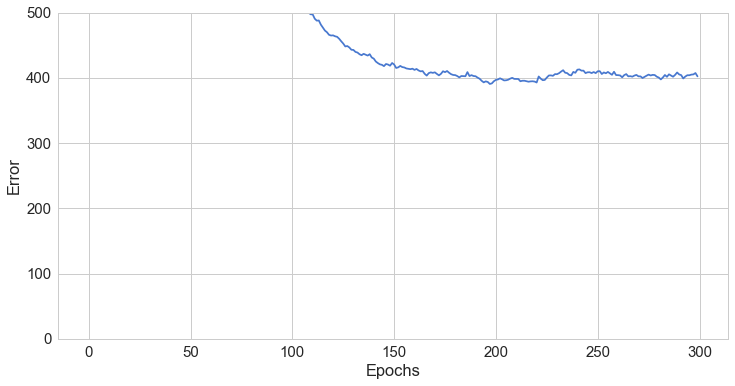

In [72]:
# From the author, just calls to matplotlib.pyplot
plot_error(nn)

In [73]:
print('Train Accuracy: %.2f%%' % (nn.score(X_train, y_train) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 91.20%
Test Accuracy: 92.00%


Note: These values are actually better than the author's posted values, and there is only one difference in our code except for the comments.  This is that his training and testing sets are swapped inadvertently.  Instead of setting 500 instances aside for evaluation, he used only the first 500 instances for training, and evaluated on the rest.

Below I will show a correct prediction along with the probabilities that the model came up with.

In [74]:
nn.predict_proba(X_test[1:2])

array([[ 0.08439398,  0.08458979,  0.08439616,  0.22717785,  0.08438487,
         0.09738396,  0.08438233,  0.08446771,  0.08441068,  0.08441267]])

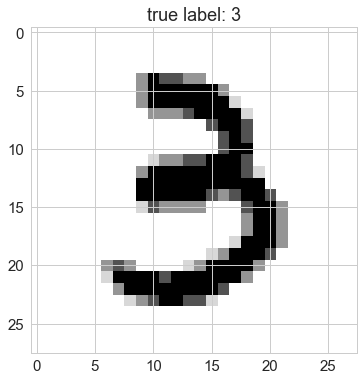

In [75]:
plot_digit(X_test, y_test, idx=1)

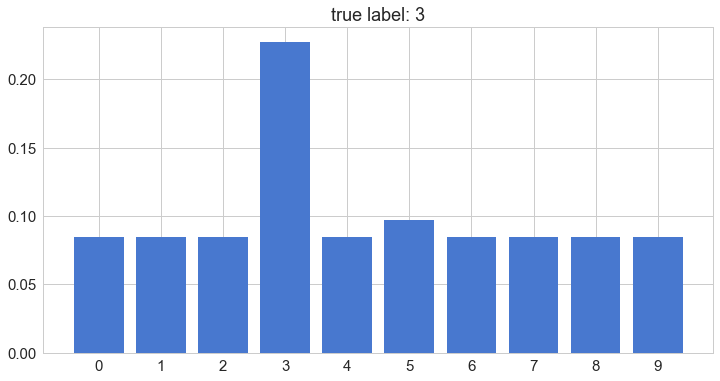

In [76]:
plot_digit_dist(X_test, y_test, idx=1, model=nn)

Below is an example of a failed prediction.

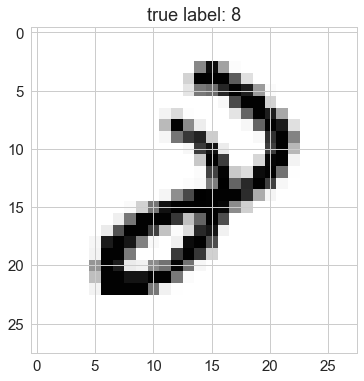

In [103]:
plot_digit(X_test, y_test, idx=31)

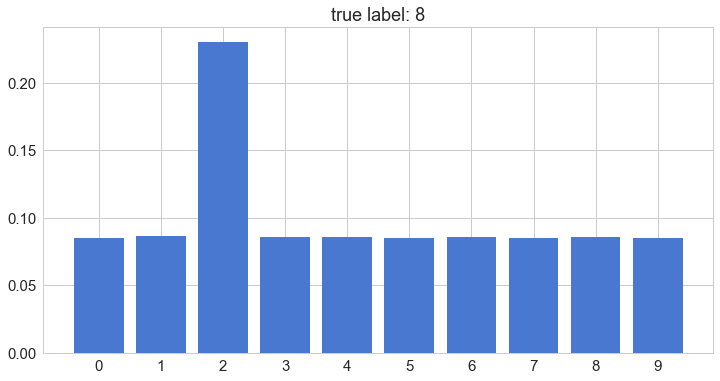

In [102]:
plot_digit_dist(X_test, y_test, idx=31, model=nn)

Now I will use sklearn.preprocessing to scale the input data and see if my results improve.

In [104]:
from sklearn.preprocessing import scale, normalize

X_train_std = scale(X_train.astype(np.float64))
X_test_std = scale(X_test.astype(np.float64))

nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=50,
                  l2=0.5,
                  l1=0.0,
                  epochs=300,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train_std, y_train);

print('Test Accuracy: %.2f%%' % (nn.score(X_test_std, y_test) * 100))

Test Accuracy: 95.00%


Using 250 hidden units and increasing the epochs to 500 actually gives a worse result (87.60% Test Accuracy) but after looking at the error plot it appears it overshot a local minima and should be inspected after epoch 275.  Alternatively, the learning rate could be scaled down past this point.

In [133]:
nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=250,
                  l2=0.5,
                  l1=0.0,
                  epochs=275,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train, y_train);

print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Test Accuracy: 81.40%


Looks like that failed, but I think it's because 250 was a visual guess.  From this point I will cut the learning rate in half and run 50 more epochs with the already trained model.

In [134]:
nn.learning_rate=0.0005
nn.epochs=50
nn.fit(X_train, y_train)

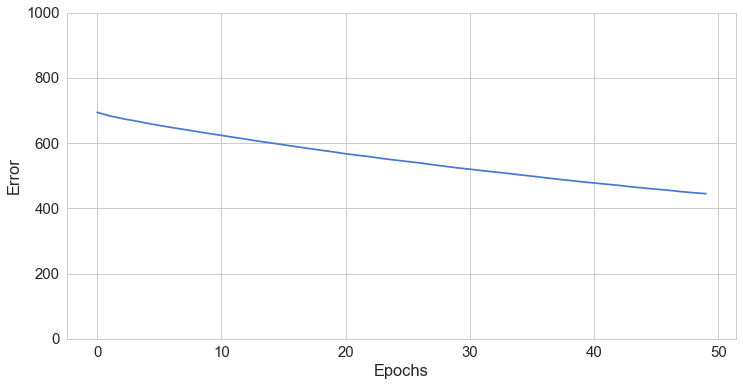

In [137]:
def plot_larger_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylim([0, 1000])
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()
    
plot_larger_error(nn)

In [136]:
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Test Accuracy: 95.00%


That worked!  It beats the first training attempt, although it does not beat the normalized inputs alone.  I think with more massaging this could be improved, but I'll move on.

Now I will combine both strategies as the author recommends to see if it will improve further.

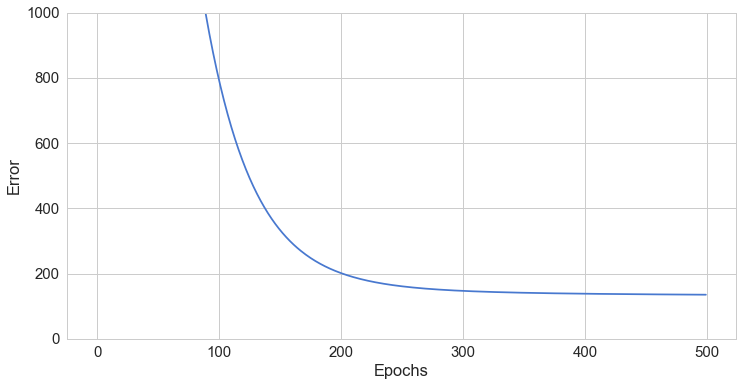

Test Accuracy: 97.60%


In [118]:
from sklearn.preprocessing import scale, normalize

X_train_std = scale(X_train.astype(np.float64))
X_test_std = scale(X_test.astype(np.float64))

nn = NNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  n_hidden_units=250,
                  l2=0.5,
                  l1=0.0,
                  epochs=500,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

nn.fit(X_train_std, y_train);

plot_larger_error(nn)

print('Test Accuracy: %.2f%%' % (nn.score(X_test_std, y_test) * 100))

This is the best result so far, and in a vacuum is quite a good result in my opinion.

Next extension for me is to add additional layers of hidden nodes.  This will not be a trivial change since it requires full generalization of the number of weights, biases, hidden nodes, etc. and must accept any number of hidden layers with any number of nodes in each.

In [2]:
class DeepNNClassifier:
    
    # These params are pretty standard for a NN classifier, I think TF is very similar
    def __init__(self, n_classes, n_features, hidden_layers=[30],
                 l1=0.0, l2=0.0, epochs=500, learning_rate=0.01,
                 n_batches=1, random_seed=None):
        
        # Recall that a random seed was set at the beginning so this is an optional param
        if random_seed:
            np.random.seed(random_seed)
        self.n_classes = n_classes
        self.n_features = n_features
        self.hidden_layers = hidden_layers
        self.weights = self._init_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.n_batches = n_batches
        # This holds the gradients for each weight
        self.grads = [0 for z in self.weights]
        
    def print_weights(self):
        for weight in self.weights:
            print(str(len(weight)) + "x" + str(len(weight[0])))
        
    def _init_weights(self):
        weights = []       
        # first_weights connects the input layer to the first hidden layer
        first_weights = np.random.uniform(-1.0, 1.0, 
                               size=self.hidden_layers[0] * (self.n_features + 1))
        first_weights = first_weights.reshape(self.hidden_layers[0], self.n_features + 1)
        weights.append(first_weights)
        
        # This loop should produce all hidden layers except those which touch input/output layers
        for i in range(0, len(self.hidden_layers)):
            if i+1 < len(self.hidden_layers):
                next_weights = np.random.uniform(-1.0, 1.0, 
                                                 size=(self.hidden_layers[i] + 1) * self.hidden_layers[i+1])
                next_weights = next_weights.reshape(self.hidden_layers[i] + 1, self.hidden_layers[i+1])
                weights.append(next_weights)
        
        # final_weights connects the final hidden layer to the output layer
        final_weights = np.random.uniform(-1.0, 1.0,
                                         size=self.n_classes * (self.hidden_layers[-1] + 1))
        final_weights = final_weights.reshape(self.n_classes, self.hidden_layers[-1] + 1)
        weights.append(final_weights)
        return weights
        
    def _add_bias_unit(self, X, how='column'):
        # This adds a bias unit to either the first or second dimension of the input X
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1]))
            X_new[1:, :] = X
        return X_new
        
    # This represents a forward pass
    def _forward(self, X):
        # These hold the unactivated and activated hidden layers
        net_hiddens = [0 for z in self.hidden_layers]
        act_hiddens = [0 for z in self.hidden_layers]
        # Add a bias unit to X input
        net_input = self._add_bias_unit(X, how='column')
        # Initial values of hidden layer
        net_hiddens[0] = self.weights[0].dot(net_input.T)
        # Sigmoid is our activation function
        act_hiddens[0] = sigmoid(net_hiddens[0])
        # Add a bias unit to the hidden layer (on a row because each row is a node in layer)
        act_hiddens[0] = self._add_bias_unit(act_hiddens[0], how='row')
        # for each weight, apply to previous activated hidden layer and propagate forward
        for i in range(1, len(self.weights)-1):
            net_hiddens[i] = self.weights[i].T.dot(act_hiddens[i-1])
            act_hiddens[i] = sigmoid(net_hiddens[i])
            act_hiddens[i] = self._add_bias_unit(act_hiddens[i], how='row')
        # Output is last set of weights applied to activated hidden layer
        net_out = self.weights[-1].dot(act_hiddens[-1])
        # Simply apply activation to output
        act_out = sigmoid(net_out)
        return net_input, net_hiddens, act_hiddens, net_out, act_out
    
    # This is the backward pass
    def _backward(self, net_input, net_hiddens, act_hiddens, act_out, y):
        # This holds the sigmas for each layer
        self.sigmas = []
        # Params to this function are results of forward
        # sigma_final can be considered the error
        sigma_final = act_out - y
        self.sigmas.append(sigma_final)
        
        net_hiddens[-1] = self._add_bias_unit(net_hiddens[-1], how='row')
        sigma = self.weights[-1].T.dot(self.sigmas[-1]) * sigmoid_prime(net_hiddens[-1])
        sigma = sigma[1:, :]
        self.sigmas.append(sigma)
        # This loop calculates all the sigma values
        for i in range(len(net_hiddens)-2, -1, -1):
            net_hiddens[i] = self._add_bias_unit(net_hiddens[i], how='row')
            sigma = self.weights[i+1].dot(self.sigmas[-1]) * sigmoid_prime(net_hiddens[i])
            sigma = sigma[1:, :]
            self.sigmas.append(sigma)
        # Must reverse the list since sigma_final will be at the head and we are backward propagating
        self.sigmas.reverse()
        # The first grad uses net_input
        self.grads[0] = self.sigmas[0].dot(net_input)
        # This loop calculates all the remaining grad values
        for i in range(1, len(self.sigmas)):
            self.grads[i] = self.sigmas[i].dot(act_hiddens[i-1].T)
        return self.grads
    
    def _error(self, y, output):
        #L1-2 Regularization and cross_entropy loss
        L1_term = L1_reg_deep(self.l1, self.weights)
        L2_term = L2_reg_deep(self.l2, self.weights)
        error = cross_entropy(output, y) + L1_term + L2_term
        return np.mean(error) / len(self.hidden_layers)
    
    # This is the backpropagation (includes both a forward and backward pass)
    def _backprop_step(self, X, y):
        net_input, net_hiddens, act_hiddens, net_out, act_out = self._forward(X)
        # y is [n_instances, n_classes], backward assumes the transpose of this
        y = y.T
        grads = self._backward(net_input, net_hiddens, act_hiddens, act_out, y)

        # regularize
        for i in range(0, len(grads)):
            if i == 0 or i == len(grads)-1:
                grads[i][:, 1:] += (self.weights[i][:, 1:] * (self.l1 + self.l2))
            else:
                grads[i][:, 1:] += (self.weights[i].T[:, 1:] * (self.l1 + self.l2))

        error = self._error(y, act_out)
        
        return error, grads
    
    def predict(self, X):
        Xt = X.copy()
        net_input, net_hiddens, act_hiddens, net_out, act_out = self._forward(Xt)
        # mle is defined by the author and does np.argmax(y, axis=1) here to predict
        return mle(net_out.T)
    
    def predict_proba(self, X):
        Xt = X.copy()
        net_input, net_hiddens, act_hiddens, net_out, act_out = self._forward(Xt)
        # softmax gives a probability distribution adding to one across each class
        return softmax(act_out.T)
    
    def fit(self, X, y):
        self.error_ = []
        X_data, y_data = X.copy(), y.copy()
        # one_hot defined by author, returns matrix with one-hot vectors instead of just the correct label
        y_data_enc = one_hot(y_data, self.n_classes)
        for i in range(self.epochs):

            X_mb = np.array_split(X_data, self.n_batches)
            y_mb = np.array_split(y_data_enc, self.n_batches)
            
            epoch_errors = []

            for Xi, yi in zip(X_mb, y_mb):
                
                # update weights
                error, grads = self._backprop_step(Xi, yi)
                epoch_errors.append(error)
                # weights updated using gradient descent
                for i in range(0, len(self.weights)):
                    if i == 0 or i == len(self.weights)-1:
                        self.weights[i] -= (self.learning_rate * grads[i])
                    else:
                        self.weights[i] -= (self.learning_rate * grads[i].T)
            # self.error_ holds the average error across epochs
            self.error_.append(np.mean(epoch_errors))
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        # Calculates the percentage correct across the input
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

That turned out to be a pretty involved refactoring process.  Worth noting is that new L1 and L2 regularization methods are being used but they were creatd in the math_utils file.  Let's see if this model can perform adequately or even better than the previous model.

In [7]:
X, y = read_mnist(IMAGES_PATH, LABELS_PATH)
X, y = shuffle_data(X, y, random_seed=RANDOM_SEED)
X_train, y_train = X[500:], y[500:] # From 500 onward
X_test, y_test = X[:500], y[:500] # First 500 pairs

from sklearn.preprocessing import scale, normalize

X_train_std = scale(X_train.astype(np.float64))
X_test_std = scale(X_test.astype(np.float64))

In [8]:
dnn = DeepNNClassifier(n_classes=N_CLASSES, 
                  n_features=N_FEATURES,
                  hidden_layers=[250, 50, 10],
                  l2=0.50,
                  l1=0.00,
                  epochs=500,
                  learning_rate=0.001,
                  n_batches=25,
                  random_seed=RANDOM_SEED)

dnn.fit(X_train_std, y_train)
print('Test Accuracy: %.2f%%' % (dnn.score(X_test_std, y_test) * 100))

Test Accuracy: 98.40%


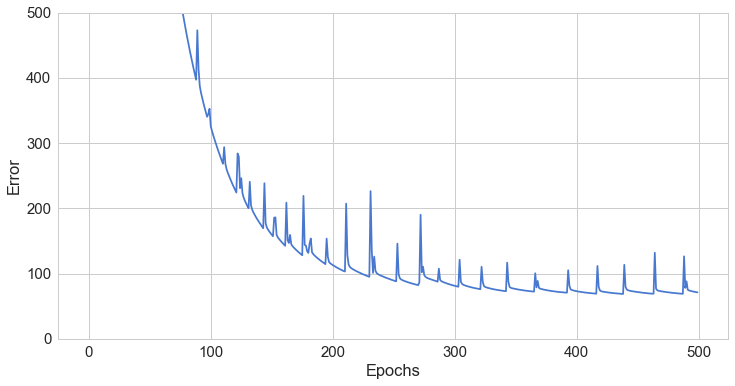

In [9]:
plot_error(dnn)

Cool!  So this model was able to crack 98% accuracy, the best of any model in this notebook, but the error graph is puzzling.  Why does the error spike up and down every ~20-25 epochs?  I'll have to examine this more closely, since solving this could allow for quicker convergence and thus better accuracy on the same number of epochs.